<h1><b>Những mô hình hồi quy (regression) và phương pháp đánh giá (metrics)

Trong lĩnh vực machine learning, các mô hình máy học đóng vai trò cốt lõi nên việc xây dựng và sử dụng các mô hình máy học là một phần kiến thức quan trọng. Một trong những nhiệm vụ quan trọng của học máy là mô hình hóa các mối quan hệ tuyến tính trong dữ liệu. Trong bài tập này, chúng ta sẽ tập trung vào bài toán hồi quy, một phần quan trọng của machine learning, để dự đoán một biến mục tiêu dựa trên các biến khác.

Trong bài tập này, chúng ta sẽ đào sâu vào các bước cơ bản của việc xây dựng và đánh giá mô hình. Chúng ta sẽ trải nghiệm chúng thông qua một bài tập với các nhiệm vụ chính như:

* Xây dựng bộ dự liệu
* Huấn luyện mô hình
* Đánh giá mô hình

Khi bạn hoàn thành bài tập này, bạn sẽ có hiểu biết thực tế về việc sử dụng Python và thư viện machine learning để giải quyết bài toán hồi quy. Kỹ năng này là quan trọng trong việc xây dựng các ứng dụng dự đoán và phân tích dữ liệu trong nhiều lĩnh vực khác nhau.

Ta cần import những thư viện cần thiết

In [33]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
np.random.seed(0)

Ở đây ta sẽ tìm hiểu về những mô hình regression như: Linear Regression, Decision Tree Regressor, SVR, KNeighbors Regressor

### 1. Chuẩn bị dữ liệu dữ liệu

Đầu tiên ta cần đọc dữ liệu từ file csv `USA_Housing.csv` bằng `pandas` như những bài trước và gán vào biến `df`

In [34]:
df = pd.read_csv('./data/USA_Housing.csv')

Kiểm tra một số giá trị của df

In [35]:
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [4]:
df.isna().sum()

Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
dtype: int64

Ta nhận thấy dataframe này không bị khuyết dữ liệu

Ta sẽ bỏ đi cột `Address` vì trong khuôn khổ bài này ta sẽ không cần gian tâm đến các giá trị đó

In [36]:
### BEGIN SOLUTION
df.drop(columns=['Address'], inplace=True)
### END SOLUTION

In [6]:
assert df.shape == (5000, 6)

Ở đây ta sẽ dùng `MinMaxScaler` để scale cột `Avg. Area Income` và `Area Population`

<details>
<summary><strong>Hàm MinMaxScaler() để làm gì?</strong></summary>

**MinMaxScaler** dùng để **chuẩn hoá dữ liệu về cùng một thang đo**, thường là **[0, 1]** theo công thức:

x' = (x − min(x)) / (max(x) − min(x))

**Bản chất**
- Giữ nguyên **quan hệ tương đối** giữa các giá trị  
- Chỉ thay đổi **độ lớn tuyệt đối**

Trong ML, đặc biệt với các mô hình **dựa trên khoảng cách** hoặc **tối ưu hoá bằng gradient**, scale là **bắt buộc**, không phải trang trí.
</details>

---

<details>
<summary><strong>Tại sao cần scale trong bài toán này?</strong></summary>

Hai feature có thang đo rất khác nhau:
- `Avg. Area Income` → cỡ **vài chục nghìn**
- `Area Population` → cỡ **vài trăm nghìn**

**Nếu không scale**
- Feature có giá trị lớn hơn sẽ **chi phối model**
- **Gradient descent đi lệch hướng**
- Model “tưởng” population quan trọng hơn income chỉ vì… **số nó to**

**Scale giúp**
- Các feature được nhìn **công bằng**
- Model học được **bản chất**, không bị đánh lừa bởi đơn vị đo
</details>

---

<details>
<summary><strong>Tại sao chỉ scale 2 feature này?</strong></summary>

Chỉ **feature dạng số liên tục (continuous)** mới cần scale.

Các cột khác thường là:
- **Binary** (0/1)
- **Label** (`target`)
- Feature đã **cùng thang đo**

> Scale `target` là **sai** (trừ regression đặc biệt)  
> Scale **categorical** là **sai hoàn toàn**

→ Hai cột này vừa **liên tục**, vừa **chênh lệch thang đo lớn**, nên phải scale.
</details>

---

<details>
<summary><strong>Vì sao phải reshape(-1, 1)?</strong></summary>

`sklearn` **không nhận vector 1 chiều** cho scaler.  
Nó yêu cầu input dạng **ma trận 2D**:

- Shape đúng: `(n_samples, n_features)`
- Series / array thường là `(n_samples,)` → **sai**

**Ý nghĩa `reshape(-1, 1)`**
- `-1`: tự suy ra số dòng
- `1`: mỗi feature là **1 cột**

**Ví dụ**
(1000,) → reshape → (1000, 1)

css
Copy code

→ Không reshape là **lỗi ngay**.

| Method            | Dạng input yêu cầu                        | 1 feature (vector 1D)          | N features (2D)          | Ghi chú                                                       |
| ----------------- | ----------------------------------------- | ------------------------------ | ------------------------ | ------------------------------------------------------------- |
| **fit**           | X_train: `(n_samples, n_features)`        | `(m,1)` → phải `reshape(-1,1)` | `(m,n)` → dùng trực tiếp | Học parameters từ dữ liệu (mean/std, min/max, model weights…) |
| **fit_transform** | X_train: `(n_samples, n_features)`        | `(m,1)` → reshape              | `(m,n)` → trực tiếp      | Fit + transform data, thường dùng cho scaler/preprocessor     |
| **transform**     | X (train/test): `(n_samples, n_features)` | `(m,1)` → reshape              | `(m,n)` → trực tiếp      | Chỉ transform dựa trên fit trước đó, **không fit lại**        |
| **predict**       | X_test: `(n_samples, n_features)`         | `(m,1)` → reshape              | `(m,n)` → trực tiếp      | Dự đoán nhãn / giá trị, cần cùng số feature với fit           |

</details>

---

<details>
<summary><strong>Tại sao fit_transform từng cột riêng? Có vấn đề gì không?</strong></summary>

Cách này **chạy được**, nhưng tư duy ML **chưa tối ưu**.

**Chuẩn hơn**
- `fit` scaler trên **train set**
- `transform` cho **test set**
- Scale **nhiều cột cùng lúc**

**Lý do**
- Tránh **data leakage**
- Dễ quản lý **pipeline**
- Đúng chuẩn **production**

Với mục đích **học / demo** → cách này **chấp nhận được**.
</details>

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
df['Avg. Area Income'] = scale.fit_transform(np.array(df['Avg. Area Income']).reshape(-1, 1))
df['Area Population'] = scale.fit_transform(np.array(df['Area Population']).reshape(-1, 1))
df

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,0.686822,5.682861,7.009188,4.09,0.329942,1.059034e+06
1,0.683521,6.002900,6.730821,3.09,0.575968,1.505891e+06
2,0.483737,5.865890,8.512727,5.13,0.528582,1.058988e+06
3,0.506630,7.188236,5.586729,3.26,0.491549,1.260617e+06
4,0.469223,5.040555,7.839388,4.23,0.376988,6.309435e+05
...,...,...,...,...,...,...
4995,0.475738,7.830362,6.137356,3.46,0.326351,1.060194e+06
4996,0.675097,6.999135,6.576763,4.02,0.366362,1.482618e+06
4997,0.507135,7.250591,4.805081,2.13,0.476515,1.030730e+06
4998,0.558419,5.534388,7.130144,5.44,0.611282,1.198657e+06


Tiếp đến ta sẽ chia dữ liệu thành tập train và test bằng `train_test_split`
* Ta gán biến `y` bằng dữ liệu ở cột `Price`
* Ta gán biến `x` là dữ liệu ở tất cả các cột còn lại
* Sau đó dùng `train_test_split` để chia **x_train, x_test, y_train, y_test = .......** với `random_state=42, test_size=0.01 (điều này có nghĩa 99% dữ liệu ban đầu sẽ dành để huấn luyện và phần còn lại sẽ dùng để kiểm tra)`

In [38]:
### BEGIN SOLUTION
y = df['Price']
x = df.drop(columns=['Price'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, random_state=42)   



### END SOLUTION

### 2. Huấn luyện và đánh giá mô hình

#### 2.1 Mô hình Linear Regression

Để dùng mô hình Linear Regression ta cần
* Khởi tạo một đối tượng mô hình `LinearRegression` và gán nó cho biến `li_r = ......`
* Sau đó huấn luyện mô hình khởi tạo trước đó sử dụng dữ liệu `x_train`, `y_train`
* Predict ra kết quả của `x_test` và gán vào biến `pred_li = .......`

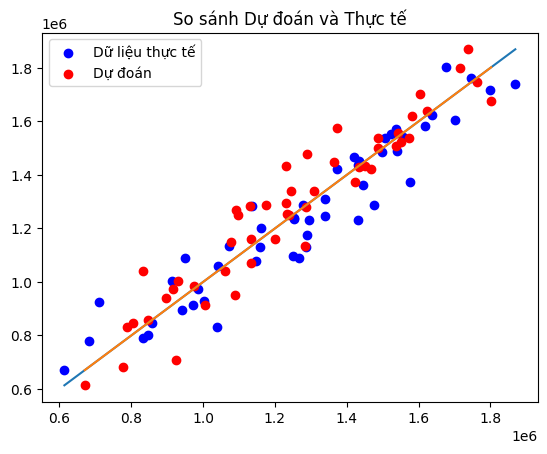

In [ ]:
### BEGIN SOLUTION
li_r = LinearRegression()
li_r.fit(x_train,y_train)
pred_li = li_r.predict(x_test)
### END SOLUTION

import matplotlib.pyplot as plt
# biểu đồ so sánh dự đoán và thực tế
plt.scatter(y_test, pred_li, c='blue', label='Dữ liệu thực tế')
plt.scatter(pred_li, y_test, c='red', label='Dự đoán')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-')
plt.plot([min(pred_li), max(pred_li)], [min(pred_li), max(pred_li)], linestyle='-')
plt.title("So sánh Dự đoán và Thực tế")
plt.legend() # hiện label

Đây là phân bố của dữ liệu đã dự đoán và thực tế

Quá trình so sánh giữa `predict` và `thực tế` gọi là validation

Ở bước này, ta cần tính độ đo `MSE` bằng hàm `mean_squared_error` và gán vào biến `mse_li`

In [13]:
### BEGIN SOLUTION
mse_li = mean_squared_error(y_true=y_test, y_pred= pred_li)
### END SOLUTION
mse_li

9405950502.28123

Và ta cũng có thể tính độ đo `MAE` bằng hàm `mean_absolute_error` và gán vào biến `mae_li`

In [15]:
### BEGIN SOLUTION
mae_li = mean_absolute_error(y_true=y_test, y_pred= pred_li)
### END SOLUTION
mae_li

75146.34059795726

#### 2.2 Mô hình Decision Tree Regressor

Tiếp đến là một mô hình regression khác đó là `DecisionTreeRegressor`
* Cũng giống mô hình Linear Regression, đầu tiên ta cần khởi tạo đối tượng `DecisionTreeRegressor` và gán vào biến `de_r`
* Tiếp đến ta `fit` `x_train và y_train` ở trên vào mô hình
* Ta dùng phương thức `predict` của mô hình để predict `x_test` và gán vào biến `pred_tree`

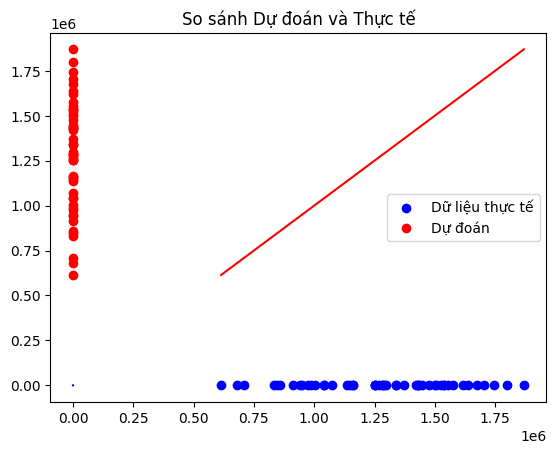

In [30]:
### BEGIN SOLUTION
de_r = DecisionTreeRegressor()
de_r.fit(x_train, y_train)
pred_tree = de_r.predict(x_test)

### END SOLUTION
import matplotlib.pyplot as plt

plt.scatter(y_test, pred_tree, c='blue', label='Dữ liệu thực tế')
plt.scatter(pred_tree, y_test, c='red', label='Dự đoán')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color ='red')
plt.plot([min(pred_tree), max(pred_tree)], [min(pred_tree), max(pred_tree)], linestyle='-', color ='blue')
plt.title("So sánh Dự đoán và Thực tế")
plt.legend()

Tương tự như trên, ta tính độ đo `MSE` và gán vào biến `mse_tree`

In [17]:
### BEGIN SOLUTION
mse_tree = mean_squared_error(y_true=y_test, y_pred= pred_tree)
### END SOLUTION
mse_tree

34201780085.58606

Tương tự như trên, ta tính độ đo `MAE` và gán vào biến `mae_tree`

In [18]:
### BEGIN SOLUTION
mae_tree = mean_absolute_error(y_true=y_test, y_pred= pred_tree)
### END SOLUTION
mae_tree

147530.89203945897

#### 2.3 Mô hình Support Vector Regression (SVR)

Tiếp đến là một mô hình regression khác đó là `SVR`
* Cũng giống các mô hình trên, đầu tiên ta cần khởi tạo đối tượng `SVR` và gán vào biến `svr`
* Tiếp đến ta `fit` `x_train và y_train` ở trên vào mô hình
* Ta dùng phương thức `predict` của mô hình để predict `x_test` và gán vào biến `pred_svr`

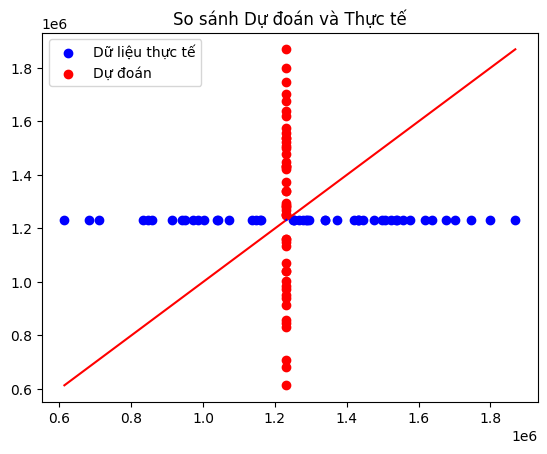

In [39]:
### BEGIN SOLUTION
svr = SVR()
svr.fit(x_train, y_train)
pred_svr = svr.predict(x_test)

### END SOLUTION
import matplotlib.pyplot as plt

plt.scatter(y_test, pred_svr, c='blue', label='Dữ liệu thực tế')
plt.scatter(pred_svr, y_test, c='red', label='Dự đoán')
# Dòng 1: (x = y_thật, y = y_dự_đoán)

# Dòng 2: (x = y_dự_đoán, y = y_thật)

# 👉 Chúng là ảnh gương qua đường y = x

# Không có ý nghĩa ML gì thêm cả — chỉ làm rối hình
# 👉 Trong thực tế KHÔNG nên vẽ cả hai

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color ='red')
plt.plot([min(pred_svr), max(pred_svr)], [min(pred_svr), max(pred_svr)], linestyle='-', color ='blue')
plt.title("So sánh Dự đoán và Thực tế")
plt.legend()

Dải ngang
y_dự_đoán ≈ hằng số


→ Bất kể y_thật là bao nhiêu
→ Model trả về gần như cùng 1 giá trị

👉 Model KHÔNG học được mối quan hệ x → y

Dải dọc
y_thật ≈ hằng số


→ Dữ liệu test có rất nhiều giá trị y giống nhau
hoặc bị quantize / clip

ta thấy học như nào thì dự đoán là ra hằng gần 1.2 nên mô hình này kém

Tương tự ở đây ta sẽ tính độ đo `MSE` và gán vào biến `mse_svr`

trường hợp trên do 1. Chưa scale dữ liệu (rất hay gặp với SVR)

SVR bắt buộc scale.

Nếu không:

Kernel RBF bị “tê liệt”

Model trả về gần mean(y)

x' = (x − mean(x)) / std(x)


In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# x_train1 = scaler_x.fit_transform(x_train)
# x_test1  = scaler_x.transform(x_test)

# y_train1 = scaler_y.fit_transform(
#     y_train.to_numpy().reshape(-1,1)
# ).ravel()


NameError: name 'y_train1' is not defined

In [24]:
### BEGIN SOLUTION
mse_svr = mean_squared_error(y_true=y_test, y_pred= pred_svr)
### END SOLUTION
mse_svr

93305056656.22443

Và độ đo `MAE` và gán vào biến `mae_svr`

In [25]:
### BEGIN SOLUTION
mae_svr = mean_absolute_error(y_true=y_test, y_pred= pred_svr)
### END SOLUTION
mae_svr

256152.25430667962

#### 2.4 Mô hình K-Neighbors Regressor

Mô hình cuối cùng ta tìm hiểu trong bài này đó là `KNRegressor`
* Đầu tiên ta cần khởi tạo đối tượng mô hình `KNeighborsRegressor` với tham số `n_neighbors=5` và gán vào biến `knr`
* Sau đó ta `fit` và `predict` như ở trên và gán vào biến `pred_knr`

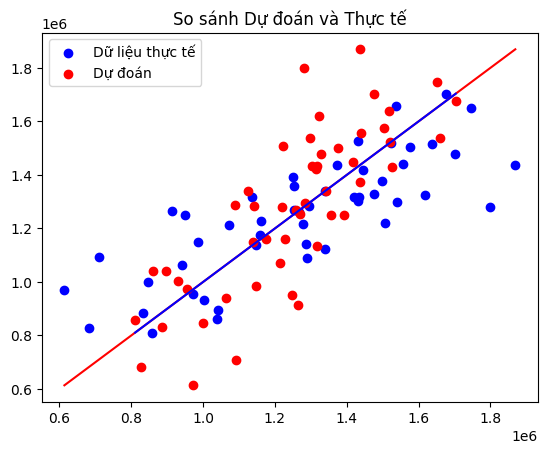

In [40]:
### BEGIN SOLUTION
knr = KNeighborsRegressor(n_neighbors=5)
knr.fit(x_train, y_train)
pred_knr = knr.predict(x_test)




### END SOLUTION

plt.scatter(y_test, pred_knr, c='blue', label='Dữ liệu thực tế')
plt.scatter(pred_knr, y_test, c='red', label='Dự đoán')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color ='red')
plt.plot([min(pred_knr), max(pred_knr)], [min(pred_knr), max(pred_knr)], linestyle='-', color ='blue')
plt.title("So sánh Dự đoán và Thực tế")
plt.legend()

Ta tiếp tục tính 2 độ đo `MSE` và `MAE` và lần lượt gán vào 2 biến `mse_knn` và `mae_knn`

In [41]:
### BEGIN SOLUTION
mse_knr = mean_squared_error(pred_knr, y_test)
### END SOLUTION
mse_knr

34373343769.55536

In [42]:
### BEGIN SOLUTION
mae_knr = mean_absolute_error(pred_knr, y_test)
### END SOLUTION
mae_knr

143461.55096352854

### 3. So sánh kết quả các mô hình

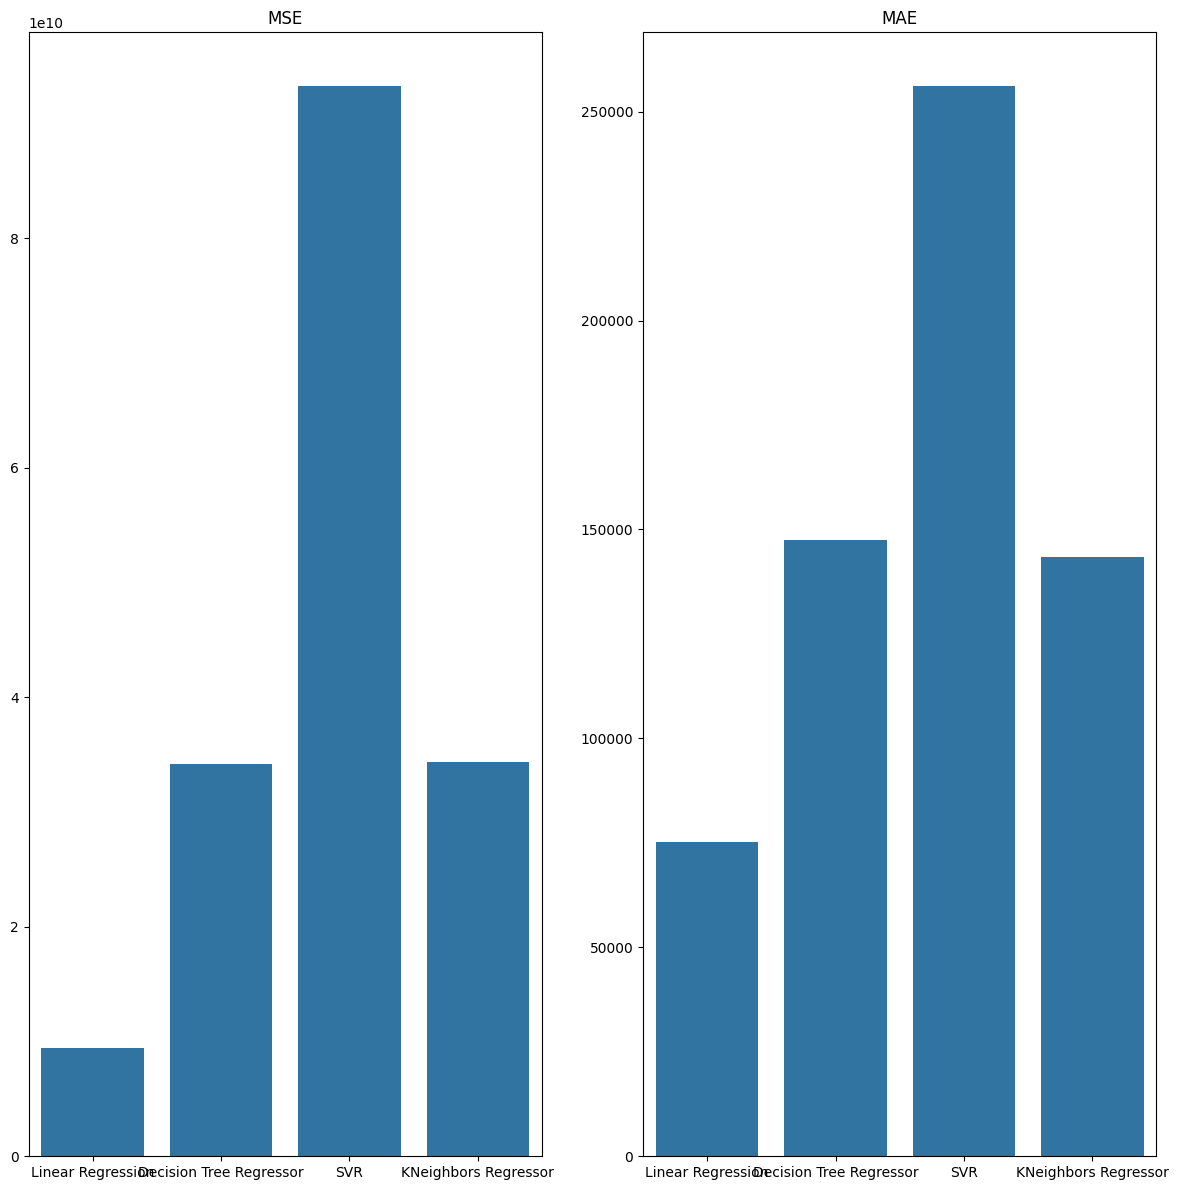

In [ ]:
import seaborn as sns
mse = [mse_li, mse_tree, mse_svr, mse_knr]
mae = [mae_li, mae_tree, mae_svr, mae_knr]
label = ['Linear Regression', 'Decision Tree Regressor', 'SVR', 'KNeighbors Regressor']
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
sns.barplot(x=label, y=mse, ax=ax[0])
ax[0].set_title('MSE')
sns.barplot(x=label, y=mae, ax=ax[-1])
ax[1].set_title('MAE')
plt.tight_layout()

Qua biểu đồ trên, ta có thể thấy được với dữ liệu này thì mô hình `Linear Regression` sẽ cho kết quả tốt nhất trong 4 mô hình